# Intro to PyTorch

What comes today:
- Introduction to PyTorch
- Automatic gradient computation
- Logistic regression (it's a neural network, actually ;) )

__This notebook__ will teach you to use pytorch low-level core. You can read about it [here](http://pytorch.org/).

__Pytorch feels__ differently than other frameworks (like tensorflow/theano) on almost every level. TensorFlow makes your code live in two "worlds" simultaneously:  symbolic graphs and actual tensors. First you declare a symbolic "recipe" of how to get from inputs to outputs, then feed it with actual minibatches of data.  In pytorch, __there's only one world__: all tensors have a numeric value.

You compute outputs on the fly without pre-declaring anything. The code looks exactly as in pure numpy with one exception: pytorch computes gradients for you. And can run stuff on GPU. And has a number of pre-implemented building blocks for your neural nets. [And a few more things.](https://medium.com/towards-data-science/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b)

Let's dive into it!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
torch.__version__

'2.3.0'

In [3]:
# numpy world

x = np.arange(16).reshape(4, 4)

print("X :\n%s\n" % x)
print("X.shape : %s\n" % (x.shape,))
print("add 5 :\n%s\n" % (x + 5))
print("X*X^T  :\n%s\n" % np.dot(x, x.T))
print("mean over cols :\n%s\n" % (x.mean(axis=-1)))
print("cumsum of cols :\n%s\n" % (np.cumsum(x, axis=0)))

X :
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]

X.shape : (4, 4)

add 5 :
[[ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]
 [17 18 19 20]]

X*X^T  :
[[ 14  38  62  86]
 [ 38 126 214 302]
 [ 62 214 366 518]
 [ 86 302 518 734]]

mean over cols :
[ 1.5  5.5  9.5 13.5]

cumsum of cols :
[[ 0  1  2  3]
 [ 4  6  8 10]
 [12 15 18 21]
 [24 28 32 36]]



In [4]:
# pytorch world

x = np.arange(16).reshape(4, 4)

x = torch.tensor(x, dtype=torch.float32)  # or torch.arange(0,16).view(4,4)

print("X :\n%s" % x)
print("X.shape : %s\n" % (x.shape,))
print("add 5 :\n%s\n" % (x + 5))
print("X*X^T  :\n%s\n" % torch.matmul(x, x.transpose(1, 0)))  # short: x.mm(x.t())
print("mean over cols :\n%s\n" % torch.mean(x, dim=-1))
print("cumsum of cols :\n%s" % torch.cumsum(x, dim=0))

X :
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]])
X.shape : torch.Size([4, 4])

add 5 :
tensor([[ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.],
        [17., 18., 19., 20.]])

X*X^T  :
tensor([[ 14.,  38.,  62.,  86.],
        [ 38., 126., 214., 302.],
        [ 62., 214., 366., 518.],
        [ 86., 302., 518., 734.]])

mean over cols :
tensor([ 1.5000,  5.5000,  9.5000, 13.5000])

cumsum of cols :
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  6.,  8., 10.],
        [12., 15., 18., 21.],
        [24., 28., 32., 36.]])


#### NumPy and Pytorch

As you can notice, pytorch allows you to hack stuff much the same way you did with numpy. This means that you can _see the numeric value of any tensor at any moment of time_. Debugging such code can be done with by printing tensors or using any debug tool you want (e.g. [gdb](https://wiki.python.org/moin/DebuggingWithGdb)).

You could also notice the a few new method names and a different API. So no, there's no compatibility with numpy [yet](https://github.com/pytorch/pytorch/issues/2228) and yes, you'll have to memorize all the names again. Get excited!

For example, 
* If something takes a list/tuple of axes in numpy, you can expect it to take *args in pytorch
 * `x.reshape([1,2,8]) -> x.view(1,2,8)`
* You should swap _axis_ for _dim_ in operations like mean or cumsum
 * `x.sum(axis=-1) -> x.sum(dim=-1)`
* most mathematical operations are the same, but types an shaping is different
 * `x.astype('int64') -> x.type(torch.LongTensor)`

To help you acclimatize, there's a [table](https://github.com/torch/torch7/wiki/Torch-for-Numpy-users) covering most new things. There's also a neat [documentation page](http://pytorch.org/docs/master/).

Finally, if you're stuck with a technical problem, we recommend searching [pytorch forumns](https://discuss.pytorch.org/). Or just googling, which usually works just as efficiently. 

If you feel like you almost give up, remember two things: __GPU__ and __free gradients__. Besides you can always jump back to numpy with x.numpy()

## Warmup: trigonometric knotwork

_inspired by [this post](https://www.quora.com/What-are-the-most-interesting-equation-plots)_

There are some simple mathematical functions with cool plots. For one, consider this:

$$ x(t) = t - 1.5 * cos( 15 t) $$
$$ y(t) = t - 1.5 * sin( 16 t) $$


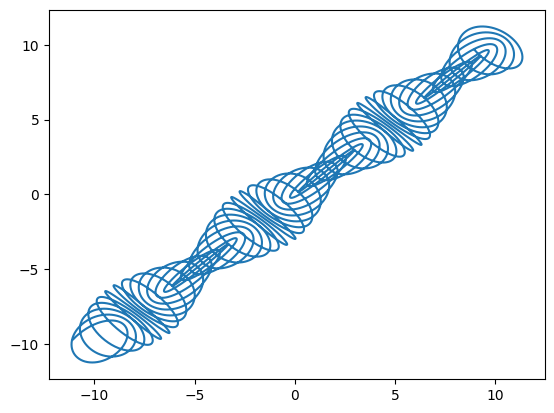

In [5]:
t = torch.linspace(-10, 10, steps=10000)

# compute x(t) and y(t) as defined above
x = t - 1.5 * torch.cos(15 * t)
y = t - 1.5 * torch.sin(16 * t)

plt.plot(x.numpy(), y.numpy())

if you're done early, try adjusting the formula and seing how  it affects the function

## Automatic gradients

Any self-respecting DL framework must do your backprop for you. Torch handles this with the `autograd` module.

The general pipeline looks like this:
* When creating a tensor, you mark it as `requires_grad`:
    * `torch.zeros(5, requires_grad=True)`
    * `torch.tensor(np.arange(5), dtype=torch.float32, requires_grad=True)`
* Define some differentiable `loss = arbitrary_function(a)`
* Call `loss.backward()`
* Gradients are now available as ```a.grads```

__Here's an example:__ let's fit a linear regression on Boston house prices

In [14]:
# from sklearn.datasets import load_boston
import pandas as pd
import numpy as np

raw_df = pd.read_csv('BostonHousing.csv', sep=",")
raw_df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [15]:
data = raw_df.loc[:, raw_df.columns.drop('medv')].values
target = raw_df['medv'].values

In [16]:
# data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
# target = raw_df.values[1::2, 2]

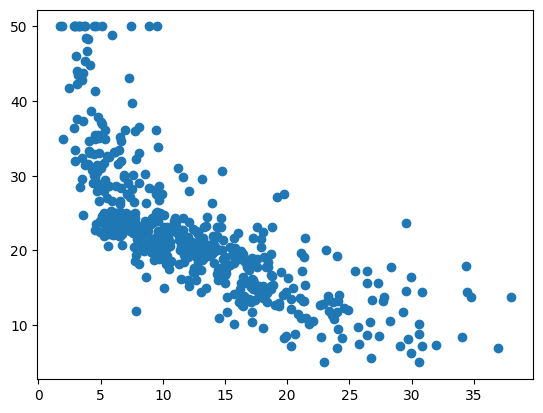

In [17]:
# boston = load_boston()
plt.scatter(data[:, -1], target)

In [18]:
w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

x = torch.tensor(data[:, -1] / 10, dtype=torch.float32)
y = torch.tensor(target, dtype=torch.float32)

In [19]:
y_pred = w * x + b
loss = torch.mean((y_pred - y) ** 2)

# propagate gradients
loss.backward()

The gradients are now stored in `.grad` of those variables that require them.

In [20]:
print("dL/dw = {}\n".format(w.grad))
print("dL/db = {}\n".format(b.grad))

dL/dw = tensor([-47.3514])

dL/db = tensor([-45.0656])



If you compute gradient from multiple losses, the gradients will add up at variables, therefore it's useful to __zero the gradients__ between iteratons.

In [21]:
from IPython.display import clear_output

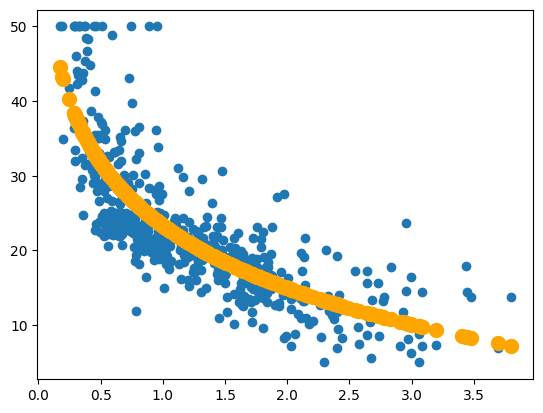

loss =  28.3435


In [22]:
w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

x = torch.tensor(data[:, -1] / 10, dtype=torch.float32)
y = torch.tensor(target, dtype=torch.float32)

for i in range(100):
    y_pred = w * torch.log(x) + b
    loss = torch.mean((y_pred - y) ** 2)
    loss.backward()

    w.data -= 0.05 * w.grad.data
    b.data -= 0.05 * b.grad.data

    # zero gradients
    w.grad.data.zero_()
    b.grad.data.zero_()

    # the rest of code is just bells and whistles
    if (i + 1) % 5 == 0:
        clear_output(True)
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.scatter(x.data.numpy(), y_pred.data.numpy(), color="orange", linewidth=5)
        plt.show()

        print("loss = ", loss.data.numpy())
        if loss.data.numpy() < 0.5:
            print("Done!")
            break

__Quest__: try implementing and writing some nonlinear regression. You can try quadratic features or some trigonometry, or a simple neural network. The only difference is that now you have more variables and a more complicated `y_pred`. 

Suprizingly, we were walking really close to the edge. Look a few cells above. We have divided the `x` values by 10 times. Let's what happens if we don't:

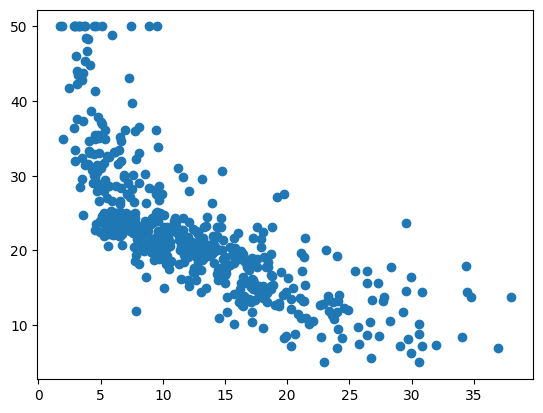

loss =  nan


In [23]:
# Now we do not divide the x values by 10. See what happens next
x = torch.tensor(data[:, -1], dtype=torch.float32)

w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

grad_history = []

for i in range(100):
    y_pred = w * x + b
    loss = torch.mean((y_pred - y) ** 2)
    loss.backward()
    grad_history.append((w.grad.item(), b.grad.item()))

    # Be extremely careful with accessing the .data attribute!
    w.data -= 0.05 * w.grad.data
    b.data -= 0.05 * b.grad.data

    # zero gradients
    w.grad.data.zero_()
    b.grad.data.zero_()

    # the rest of code is just bells and whistles
    if (i + 1) % 5 == 0:
        clear_output(True)
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.scatter(x.data.numpy(), y_pred.data.numpy(), color="orange", linewidth=5)
        plt.show()

        print("loss = ", loss.data.numpy())
        if loss.data.numpy() < 0.5:
            print("Done!")
            break

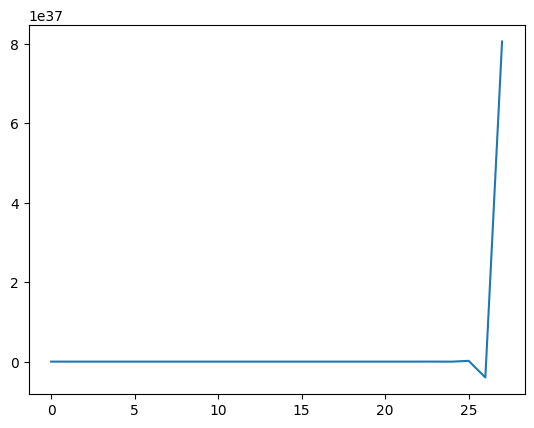

In [24]:
plt.plot([element[0] for element in grad_history])

In [25]:
print(grad_history)

[(-473.5144958496094, -45.06561279296875), (9574.380859375, 558.5819091796875), (-193146.109375, -11611.80078125), (3896813.75, 233938.40625), (-78619616.0, -4720118.5), (1586179328.0, 95229784.0), (-32001746944.0, -1921295872.0), (645646909440.0, 38762848256.0), (-13026162900992.0, -782054588416.0), (262807589224448.0, 15778237644800.0), (-5302239132385280.0, -318331735244800.0), (1.0697461300251853e+17, 6422458408108032.0), (-2.1582518525655777e+18, -1.2957544387864166e+17), (4.354351919016182e+19, 2.614231831549051e+18), (-8.785064832620476e+20, -5.274308460125199e+19), (1.772418992719395e+22, 1.0641110829050542e+21), (-3.5759200736630464e+23, -2.146883281226081e+22), (7.214548700883164e+24, 4.331415124113106e+23), (-1.455561554891737e+26, -8.738787599253472e+24), (2.9366487550019813e+27, 1.763082244723649e+26), (-5.924796215150439e+28, -3.557083003402266e+27), (1.195349280428902e+30, 7.17654445403173e+28), (-2.4116609718921758e+31, -1.4478940352621255e+30), (4.865614230945225e+32, 

As you can see, the gradients have exploded. We could avoid it by using the smaller _learning rate_ or by using _gradient clipping_.

__You should be really careful using the gradient descent even with such simple models as linear or logistic regression.__

**Remember!**

When dealing with more complex stuff like neural network, it's best if you use tensors the way samurai uses his sword. 


# High-level pytorch

So far we've been dealing with low-level torch API. While it's absolutely vital for any custom losses or layers, building large neura nets in it is a bit clumsy.

Luckily, there's also a high-level torch interface with a pre-defined layers, activations and training algorithms. 

We'll cover them as we go through a simple image recognition problem: classifying letters into __"A"__ vs __"B"__.


In [7]:
from notmnist import load_notmnist  # file notmnist.py at this directory

In [8]:
X_train, y_train, X_test, y_test = load_notmnist(letters="AB")
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

print("Train size = %i, test_size = %i" % (len(X_train), len(X_test)))

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done
Train size = 2808, test_size = 937


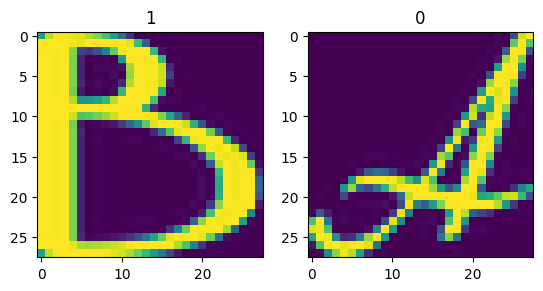

In [28]:
for i in [0, 1]:
    plt.subplot(1, 2, i + 1)
    plt.imshow(X_train[i].reshape([28, 28]))
    plt.title(str(y_train[i]))

Let's start with layers. The main abstraction here is __`torch.nn.Module`__

In [29]:
from torch import nn

In [30]:
print(nn.Module.__doc__)

Base class for all neural network modules.

    Your models should also subclass this class.

    Modules can also contain other Modules, allowing to nest them in
    a tree structure. You can assign the submodules as regular attributes::

        import torch.nn as nn
        import torch.nn.functional as F

        class Model(nn.Module):
            def __init__(self):
                super().__init__()
                self.conv1 = nn.Conv2d(1, 20, 5)
                self.conv2 = nn.Conv2d(20, 20, 5)

            def forward(self, x):
                x = F.relu(self.conv1(x))
                return F.relu(self.conv2(x))

    Submodules assigned in this way will be registered, and will have their
    parameters converted too when you call :meth:`to`, etc.

    .. note::
        As per the example above, an ``__init__()`` call to the parent class
        must be made before assignment on the child.

    :ivar training: Boolean represents whether this module is in training or
         

There's a vast library of popular layers and architectures already built for ya'.

This is a binary classification problem, so we'll train a __Logistic Regression with sigmoid__.
$$P(y_i | X_i) = \sigma(W \cdot X_i + b) ={ 1 \over {1+e^{- [W \cdot X_i + b]}} }$$


In [31]:
# create a network that stacks layers on top of each other
model = nn.Sequential()

# add first "dense" layer with 784 input units and 1 output unit.
model.add_module("l1", nn.Linear(784, 1))

# add softmax activation for probabilities. Normalize over axis 1
# note: layer names must be unique
model.add_module("l2", nn.Sigmoid())

In [32]:
print("Weight shapes:", [w.shape for w in model.parameters()])

Weight shapes: [torch.Size([1, 784]), torch.Size([1])]


In [33]:
# create dummy data with 3 samples and 784 features
x = torch.tensor(X_train[:3], dtype=torch.float32)
y = torch.tensor(y_train[:3], dtype=torch.float32)

# compute outputs given inputs, both are variables
y_predicted = model(x)[:, 0]

y_predicted  # display what we've got

tensor([0.3770, 0.4086, 0.3250], grad_fn=<SelectBackward0>)

Let's now define a loss function for our model.

The natural choice is to use binary crossentropy (aka logloss, negative llh):
$$ L = {1 \over N} \underset{X_i,y_i} \sum - [  y_i \cdot log P(y_i | X_i) + (1-y_i) \cdot log (1-P(y_i | X_i)) ]$$



In [34]:
cross_entropy = -(y * torch.log(y_predicted) + (1 - y) * torch.log(1 - y_predicted))
loss = torch.mean(cross_entropy)

assert tuple(cross_entropy.size()) == (3,), "Cross entropy must be a vector with element per sample"
assert tuple(loss.size()) == (), "Loss must be scalar. Did you forget the mean/sum?"
assert (
        cross_entropy.data.numpy()[0] > 0
), "Crossentropy must non-negative, zero only for perfect prediction"
assert loss.data.numpy() <= np.log(
    5
), "Loss is too large even for untrained model. Please double-check it."

In [35]:
# loss = nn.functional.binary_cross_entropy(y_predicted, y)

__Note:__ you can also find many such functions in `torch.nn.functional`, just type __`F.<tab>`__.

__Torch optimizers__

When we trained Linear Regression above, we had to manually .zero_() gradients on both our variables. Imagine that code for a 50-layer network.

Again, to keep it from getting dirty, there's `torch.optim` module with pre-implemented algorithms:

In [36]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

# here's how it's used:
loss.backward()  # add new gradients
opt.step()  # change weights
opt.zero_grad()  # clear gradients

In [37]:
# dispose of old variables to avoid bugs later
del x, y, y_predicted, loss, y_pred

## Putting it all together

In [38]:
# create network again just in case
model = nn.Sequential()
model.add_module("first", nn.Linear(784, 1))
model.add_module("second", nn.Sigmoid())

opt = torch.optim.SGD(model.parameters(), lr=1e-3)

In [39]:
history = []

for i in range(5000):
    # sample 256 random images
    ix = np.random.randint(0, len(X_train), 256)
    x_batch = torch.tensor(X_train[ix], dtype=torch.float32)
    y_batch = torch.tensor(y_train[ix], dtype=torch.float32)

    # predict probabilities
    y_predicted = model(x_batch)[:, 0]

    assert y_predicted.dim() == 1, "did you forget to select first column with [:, 0]"

    # compute loss, just like before
    loss = nn.functional.binary_cross_entropy(y_predicted, y_batch)

    # compute gradients
    loss.backward()

    # SGD step
    opt.step()

    # clear gradients
    opt.zero_grad()

    history.append(loss.data.numpy())

    if i % 10 == 0:
        print("step #%i | mean loss = %.3f" % (i, np.mean(history[-10:])))

step #0 | mean loss = 0.672
step #10 | mean loss = 0.586
step #20 | mean loss = 0.479
step #30 | mean loss = 0.407
step #40 | mean loss = 0.365
step #50 | mean loss = 0.325
step #60 | mean loss = 0.321
step #70 | mean loss = 0.284
step #80 | mean loss = 0.276
step #90 | mean loss = 0.261
step #100 | mean loss = 0.247
step #110 | mean loss = 0.232
step #120 | mean loss = 0.226
step #130 | mean loss = 0.235
step #140 | mean loss = 0.224
step #150 | mean loss = 0.226
step #160 | mean loss = 0.209
step #170 | mean loss = 0.206
step #180 | mean loss = 0.199
step #190 | mean loss = 0.196
step #200 | mean loss = 0.183
step #210 | mean loss = 0.200
step #220 | mean loss = 0.187
step #230 | mean loss = 0.179
step #240 | mean loss = 0.180
step #250 | mean loss = 0.163
step #260 | mean loss = 0.171
step #270 | mean loss = 0.172
step #280 | mean loss = 0.177
step #290 | mean loss = 0.158
step #300 | mean loss = 0.164
step #310 | mean loss = 0.162
step #320 | mean loss = 0.170
step #330 | mean loss

__Debugging tips:__
* make sure your model predicts probabilities correctly. Just print them and see what's inside.
* don't forget _minus_ sign in the loss function! It's a mistake 99% ppl do at some point.
* make sure you zero-out gradients after each step. Srsly:)
* In general, pytorch's error messages are quite helpful, read 'em before you google 'em.
* if you see nan/inf, print what happens at each iteration to find our where exactly it occurs.
  * If loss goes down and then turns nan midway through, try smaller learning rate. (Our current loss formula is unstable).


## Evaluation

Let's see how our model performs on test data

In [40]:
# use your model to predict classes (0 or 1) for all test samples
pred_test = model(torch.from_numpy(X_test))[:, 0]
pred_test = np.array(pred_test > 0.5)

assert isinstance(pred_test, np.ndarray), "please return np array, not %s" % type(pred_test)
assert pred_test.shape == y_test.shape, "please predict one class for each test sample"
assert np.in1d(pred_test, y_test).all(), "please predict class indexes"

accuracy = np.mean(pred_test == y_test)
print("Test accuracy: %.5f" % accuracy)

assert accuracy > 0.95, "try training longer"

print("Great job!")

Test accuracy: 0.96051
Great job!


## More about pytorch:

* Using torch on GPU and multi-GPU - [link](http://pytorch.org/docs/master/notes/cuda.html)
* More tutorials on pytorch - [link](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* Pytorch examples - a repo that implements many cool DL models in pytorch - [link](https://github.com/pytorch/examples)
* Practical pytorch - a repo that implements some... other cool DL models... yes, in pytorch - [link](https://github.com/spro/practical-pytorch)
* And some more - [link](https://www.reddit.com/r/pytorch/comments/6z0yeo/pytorch_and_pytorch_tricks_for_kaggle/)

## Outline
* PyTorch is a great choice to start writing simple (and not so simple) models from scratch
* Autodiff will help you to get the derivatives even for complex functions (if implemented correctly), so use it wisely
* Be careful with data normalization and monitor your loss/gradients values